In [56]:
%pip install transformers datasets -q

In [1]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/conreteness_ratings')

  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
ds['train'].features

{'Word': Value(dtype='string', id=None),
 'Bigram': Value(dtype='int64', id=None),
 'Conc.M': Value(dtype='float64', id=None),
 'Conc.SD': Value(dtype='float64', id=None),
 'Unknown': Value(dtype='int64', id=None),
 'Total': Value(dtype='int64', id=None),
 'Percent_known': Value(dtype='float64', id=None),
 'SUBTLEX': Value(dtype='int64', id=None)}

In [3]:
ds = ds.rename_column('Conc.M', 'avg_concreteness')

In [4]:
ds['train'][100]

{'Word': 'absorbable',
 'Bigram': 0,
 'avg_concreteness': 2.47,
 'Conc.SD': 1.36,
 'Unknown': 0,
 'Total': 30,
 'Percent_known': 1.0,
 'SUBTLEX': 0}

In [5]:
from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset 

scaler = MinMaxScaler()

processing_ds = ds['train'].to_pandas()

processing_ds['avg_concreteness'] = scaler.fit_transform(processing_ds['avg_concreteness'].to_numpy().reshape(-1, 1))

ds['train'] = Dataset.from_pandas(processing_ds)

In [6]:
ds = ds.remove_columns(['Conc.SD', 'Unknown', 'Total', 'SUBTLEX', 'Percent_known', 'Bigram'])

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    # max_length as suggested by the paper
    return tokenizer(batch['Word'], padding='max_length', truncation=True, max_length=10)

In [8]:
ds = ds.filter(lambda x: x['Word'] is not None)

Filter:   0%|          | 0/39954 [00:00<?, ? examples/s]

In [9]:
tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/39953 [00:00<?, ? examples/s]

In [10]:
tokenized_ds = tokenized_ds.rename_column('avg_concreteness', 'labels')

In [11]:
tokenized_ds = tokenized_ds['train'].train_test_split(test_size=0.1, shuffle=True)

In [12]:
tokenized_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_ds['train'], batch_size=8)
test_loader = DataLoader(tokenized_ds['test'], batch_size=8)

In [34]:
import torch
from transformers import BertModel


class BertForRegression(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.regressor = torch.nn.Linear(config.hidden_size, 1)

        for param in self.parameters():
            param.requires_grad = False

        for param in self.regressor.parameters():
            param.requires_grad = True
        
    def forward(self, input_ids, **kwargs):
        outputs = super().forward(input_ids=input_ids, **kwargs)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        concreteness_score = self.regressor(cls_output)

        return concreteness_score

In [35]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [36]:
model = BertForRegression.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForRegression: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForRegression from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForRegression from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
model(**tokenizer('hello world', return_tensors='pt').to(device))

tensor([[-0.3354]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [39]:
from torch.optim import Adam

# suggested learning rate by the paper
optimizer = Adam(model.parameters(), lr=2e-5)

In [40]:
from transformers import get_scheduler

num_epochs = 4
num_training_steps = len(train_loader) * num_epochs

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [41]:
loss_fn = torch.nn.MSELoss()

In [42]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
losses = []

model.train()
for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = loss_fn(outputs, batch['labels'].unsqueeze(-1)) 
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/17980 [00:00<?, ?it/s]

In [47]:
from scipy.stats import pearsonr

model.eval()

predictions = []
targets = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    predictions.extend(outputs.squeeze().tolist())
    targets.extend(batch["labels"].squeeze().tolist())



corr_corf, p_value = pearsonr(predictions, targets)

print(f"Pearson Correlation Coefficient: {corr_corf:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.7521
P-value: 0.0000


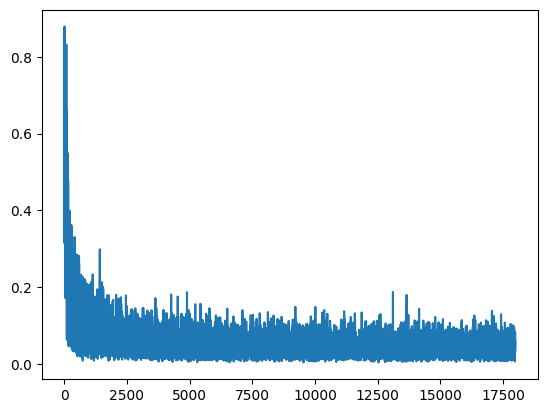

In [44]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [45]:
def predict(word):
    input_ids = tokenizer(word, return_tensors='pt').input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    return outputs.item()

In [46]:
predict('abstract'), predict('novelty'), predict('dog'), predict('cat')

(0.4193651080131531,
 0.4792586863040924,
 0.7086185216903687,
 0.5839868783950806)